![DSME-logo](./static/DSME_logo.png)

#  Reinforcement Learning and Learning-based Control

<p style="font-size:12pt";> 
<b> Prof. Dr. Sebastian Trimpe, Dr. Friedrich Solowjow </b><br>
<b> Institute for Data Science in Mechanical Engineering (DSME) </b><br>
<a href = "mailto:rllbc@dsme.rwth-aachen.de">rllbc@dsme.rwth-aachen.de</a><br>
</p>

---
TD3 (Twin Delayed Deep Deterministic Policy Gradient) Implementation

Notebook Authors: Ramil Sabirov

Adapted from: [CleanRL](https://github.com/vwxyzjn/cleanrl)

Orignal Paper: [Addressing Function Approximation Error in Actor-Critic Methods](https://arxiv.org/abs/1802.09477)

## Library Imports

In [1]:
import os
import time
import random
from datetime import datetime

import numpy as np
import matplotlib.pyplot as plt
from tqdm import notebook
from easydict import EasyDict as edict
from IPython.display import Video

import utils.helper_fns as hf

import gymnasium as gym
import custom_envs
import wandb
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from stable_baselines3.common.buffers import ReplayBuffer

os.environ['SDL_VIDEODRIVER'] = 'dummy'
os.environ['WANDB_NOTEBOOK_NAME'] = 'td3.ipynb'

plt.rcParams['figure.dpi'] = 100
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

%load_ext autoreload
%autoreload 2

## Initializations

### Experiment

We primarily use dictionaries for initializing experiment parameters and training hyperparameters. We use the `EasyDict` (imported as `edict`) library, which allows us to access dict values as attributes while retaining the operations and properties of the original python `dict`! [[Github Link](https://github.com/makinacorpus/easydict)]

In this notebook we use a few `edicts` with `exp` being one of them. It is initialized in the following cell and has keys and values containing information about the experiment being run. Although initialized in this section, we keep adding new keys and values to the dict in the later sections as well.  

This notebook supports continuous gym environments with observation space of type `gym.spaces.Box` and action space of type `gym.spaces.Box`. Eg: Pendulum-v1, MountainCarContinuous-v0, BipedalWalker-v3

In [2]:
exp = edict()

exp.exp_name = 'TD3'  # algorithm name, in this case it should be 'DDPG'

exp.env_id = 'CustomDeepPendulum-v1'  # name of the continuous gym environment to be used in this experiment.
exp.device = device.type  # save the device type used to load tensors and perform tensor operations

set_random_seed = True  # set random seed for reproducibility of python, numpy and torch
exp.seed = 2

# name of the project in Weights & Biases (wandb) to which logs are patched. (only if wandb logging is enabled)
# if the project does not exist in wandb, it will be created automatically
wandb_prj_name = f"RLLBC_{exp.env_id}"

# name prefix of output files generated by the notebook
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

if set_random_seed:
    random.seed(exp.seed)
    np.random.seed(exp.seed)
    torch.manual_seed(exp.seed)
    torch.backends.cudnn.deterministic = set_random_seed

### Agent Model Class

The `Agent` class consists of two different architectures of neural networks: a network architecture for the actor (`ActorNetwork`) and a network architecture for the Q-values (`QNetwork`). The Q-network takes state and action as input and evaluates to a scalar value that approximates the expected return until the end of the episode. The actor network takes the state as input and evaluates to a continuous action vector. Note that the actor network evaluates to an action in $[-1,1]^n$ and subsequently transforms it to the actual action space of the environment. By doing it in this way, the network always outputs a valid action - inside the boundaries of the environment's action space. To counteract the overestimation of Q-values, TD3 uses two Q-networks instead of one.

Similar to [DQN](https://arxiv.org/abs/1312.5602) the `Agent` class uses target networks to stabilize the learning process. In particular, it holds a target network for both Q-networks as well as the actor. So, in total, it makes use of 6 different networks and provides methods to query each of them, i.e. `get_q1_value`, `get_target_q1_value`, `get_q2_value`, `get_target_q2_value`, `get_action`, and `get_target_action`. 

Note that the target networks will not be subject to the optimizer, meaning they will not be modified through gradient steps. Instead, the `Agent` class provides the function `track_networks` to make the parameters of the target networks slowly track the parameters of the learned networks by the linear combination $\theta^t \leftarrow \tau\theta + (1-\tau)\theta^t$ with $\tau \ll 1$.

In [3]:
class QNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod() + np.prod(env.single_action_space.shape), 64)
        self.fc2 = nn.Linear(64, 64)
        self.fc3 = nn.Linear(64, 1)

    def forward(self, x, a):
        x = torch.cat([x, a], 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


class ActorNetwork(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.fc1 = nn.Linear(np.array(env.single_observation_space.shape).prod(), 64)
        self.fc2 = nn.Linear(64, 128)
        self.fc_mu = nn.Linear(128, np.prod(env.single_action_space.shape))

        # action rescaling
        self.register_buffer(
            "action_scale", torch.tensor((env.action_space.high - env.action_space.low) / 2.0, dtype=torch.float32)
        )
        self.register_buffer(
            "action_bias", torch.tensor((env.action_space.high + env.action_space.low) / 2.0, dtype=torch.float32)
        )

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = torch.tanh(self.fc_mu(x))
        return x * self.action_scale + self.action_bias

In [4]:
class Agent(nn.Module):
    def __init__(self, env):
        super().__init__()
        self.q1_net = QNetwork(env)
        self.q1_target_net = QNetwork(env)
        self.q2_net = QNetwork(env)
        self.q2_target_net = QNetwork(env)
        self.actor_net = ActorNetwork(env)
        self.actor_target_net = ActorNetwork(env)

        self.q1_target_net.load_state_dict(self.q1_net.state_dict())
        self.q2_target_net.load_state_dict(self.q2_net.state_dict())
        self.actor_target_net.load_state_dict(self.actor_net.state_dict())

    def get_q1_value(self, x, a):
        return self.q1_net(x, a)

    def get_target_q1_value(self, x, a):
        return self.q1_target_net(x, a)

    def get_q2_value(self, x, a):
        return self.q2_net(x, a)

    def get_target_q2_value(self, x, a):
        return self.q2_target_net(x, a)

    def get_action(self, x, greedy=True):
        return self.actor_net(x)

    def get_target_action(self, x):
        return self.actor_target_net(x)

    def track_networks(self, tau):
        for param, target_param in zip(self.actor_net.parameters(), self.actor_target_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.q1_net.parameters(), self.q1_target_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)
        for param, target_param in zip(self.q2_net.parameters(), self.q2_target_net.parameters()):
            target_param.data.copy_(tau * param.data + (1 - tau) * target_param.data)

### Training Params & Agent Hyperparams
The second dictionary we use, `hypp`, is initialized in the following cell. It has keys and values containing the hyperparameters necessary to the algorithm.

The parameters and hyperparameters in this section are broadly categorized as below:
1. Flags for logging: 
    - They are stored in the `exp` dict. 
    - This notebook uses tensorboard logging by deafult to log experiment metrics. These tb log files are saved in the directory `logs/<exp.exp_type>/<exp.run_name>/tb`. (to learn about `exp.exp_type` refer point 3. below)
    - To enable logging of gym videos of the agent's interaction with the env set `exp.capture_video = True`
    - Patch tensorboard logs and gym videos to Weigths & Biases (wandb) by setting `exp.enable_wandb_logging = True`
2. Flags and parameters to generate average performance throughout training:
    - Stored in the `exp` dict
    - If `exp.eval_agent = True`, the performance of the agent during it's training is saved in the corresponding logs folder. You can later used this to compare the performance of your current agent with other agents during their training (in Section 1.5.2).
    - Every `exp.eval_frequency` episodes the trained agent is evaluated using the `envs_eval` by playing out `exp.eval_count` episodes
    - To speed up training set `exp.eval_agent = False` 
3. Create experiment hierarchy inside log folders:
    - if `exp.exp_type` is None, experiment logs are saved to the root log directory `logs`, ie, `/logs/<exp.run_name>`, otherwise they are saved to the directory `logs/<exp.exp_type>/<exp._name>`
4. Parameters and hyperparameters related to the algorithm:
    - Stored in the `hypp` dict
    - Quick reminder:  the `num_steps` key in the `hypp` dict is also a hyperparameter defined in Env & Rollout Buffer Init Section.

Note: 
1. If Weigths and Biases (wandb) logging is enabled, when you run the "Training The Agent" cell, enter your wandb's api key when prompted. 
2. Training takes longer when either gym video recording or agent evaluation during training is enabled. To speed up training set both `exp.capture_video` and `exp.eval_agent` to `False`.

In [5]:
hypp = edict()

# flags for logging purposes
exp.enable_wandb_logging = True
exp.capture_video = True

# flags to generate agent's average performance during training
exp.eval_agent = True  # disable to speed up training
exp.eval_count = 10
exp.eval_frequency = 20

# putting the run into the designated log folder for structuring
exp.exp_type = None  # directory the run is saved to. Should be None or a string value

# agent training specific parameters and hyperparameters
hypp.total_timesteps = 50000  # the training duration in number of time steps
hypp.learning_rate = 3e-4  # the learning rate for the optimizer
hypp.gamma = 0.99  # decay factor of future rewards
hypp.buffer_size = 10000  # the size of the replay memory buffer
hypp.tau = 0.005  # target smoothing coefficient
hypp.batch_size = 512  # number of samples taken from the replay buffer for one step
hypp.exploration_noise = 0.1  # the degree of (gaussian) exploration noise
hypp.policy_noise = 0.2  # the degree of policy noise
hypp.noise_clip = 0.5  # noise clip parameter of the Target Policy Smoothing Regularization
hypp.start_learning = 10000  # the timestep the learning starts (before that the replay buffer is filled)
hypp.policy_frequency = 2  # the frequency of training the policy

### Replay Buffer
In the following cell the **replay buffer** is initialised. It is used in 2 ways:
- It **stores transitions** the agent took in the environment in the past (i.e. (state, action, next_state, reward, done?) tuples)
- It is possible to **sample a batch** of transitions from the replay buffer. The batch is used to perform a gradient step on for training.

In [6]:
# Initialization of Replay Buffer

envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(1)])

rb = ReplayBuffer(
    hypp.buffer_size,
    envs.single_observation_space,
    envs.single_action_space,
    device,
    handle_timeout_termination=False,
)

envs.close()

## Training the Agent

Before we begin training the agent, we first initialize the logging (based on the respective flags in the `exp` dict), the object of the `Agent` class and the optimizers: one for the actor network and one for the Q-network. We also initialize an initial set of observations.

After that follows the main training loop which consists of an initial **warm-up phase** followed by the **training phase**. In the warm-up phase we sample random trajectories to fill the replay buffer with observations. After that we enter the training phase which consists of:
1. **Taking a step in the environment** according to the policy defined by the actor network. The taken action is perturbed with (gaussian) noise for exploration purposes.
2. **Sampling a minibatch from the replay buffer** of previously experienced transitions. These are tuples of the form $(s,a,s',r,d)$=(state, action, next_state, reward, done) where done is a boolean indicating whether the environment has terminated after the transition.
3. **Optimizing the Q-networks** by:
    1. Compute the target actions $\tilde{a}$ in the states $s'_i$ of the minibatch by adding a small, bounded noise to the action chosen by the target actor network $\mu_t$  
    <br>$$\tilde{a}(s'_i) = \mu_t(s'_i) + \epsilon$$ with $\epsilon \sim \text{clip}(\mathcal{N}(0,\sigma), -c, c)$
    2. Calculating the targets for each transition in the minibatch. Let $Q_j'(s,a)$ denote the Q-value of the $j$-th target network in state $s$ for action $a$, then the target $T_i$ for transition $i$ of the minibatch is:  
    <br>$$\begin{equation}T_i =
\begin{cases}
r_i + \min_{j=1,2}Q_j'(s'_i,\tilde{a}(s'_i)) &, \text{if } d_i = 0\\
r_i &, \text{else}
\end{cases}
\end{equation}$$  

    3. Setting up the Q-loss functions $L_{Q_j}$ as a mean squared error (MSE) between Q-values and computed targets. Let $Q_j(s,a|\theta^{Q_j})$ be the Q-value of the $j$-th Q-network for state $s$ and action $a$, then for $j=1,2$ the Q-losses are:  
    <br>$$L_{Q_j} = \frac{1}{m}\sum_{i=1}^{m}(Q(s_i,a_i|\theta^{Q_j}) - T_i)^2$$  
    
    4. Performing a gradient descent step for the parameters of the Q-networks $\theta^{Q} = \bigcup_{j=1,2}\theta^{Q_j}$ along the gradient $\nabla_{\theta^Q} L_{Q_1} + L_{Q_2}$.
4. **Optimizing the actor network** by:
    1. Computing the policy loss $L_\mu$ for the minibatch. Let $\mu(s|\theta^\mu)$ be the action chosen by the learned actor network in state $s$, then the policy loss is:  
    <br>$$L_\mu = -\frac{1}{m}\sum_{i=1}^m Q(s_i, \mu(s_i | \theta^\mu)|\theta^{Q_1})$$  
    
    2. Performing a gradient descent step for parameters of actor network $\theta^\mu$ along the gradient $\nabla_{\theta^\mu} L_\mu$ which is equivalent to performing a gradient ascent step along the (sampled) policy gradient.
5. **Updating the target networks** by letting them track the parameters of the learned networks.

Note that steps 4 and 5 are generally not performed in every step of the main loop and thus less frequent than step 3.

Post completion of the main training loop, we save a copy of the following in the directory `logs/<exp.exp_type>/<exp.run_name>`:
1. `exp` and `hypp` dicts into a `.config` file 
2. `agent` (instance of `Agent` class) into a `.pt` file for later evaluation
3. agent performance progress throughout training into a `.csv` file if `exp.eval_agent=True`

Note: we have two vectorised gym environments, `envs` and `envs_eval` in the initalizations. `envs` is used to fill the rollout buffer with trajectories and `envs_eval` is used to evaluate the agent performance at different stages of training.

In [7]:
# reinit run_name
exp.run_name = f"{exp.env_id}__{exp.exp_name}__{exp.seed}__{datetime.now().strftime('%y%m%d_%H%M%S')}"

# init tensorboard logging and wandb logging
writer = hf.setup_logging(wandb_prj_name, exp, hypp)

# create two vectorized envs: one to fill the rollout buffer with trajectories and
# another one to evaluate the agent performance at different stages of training
envs = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed)])
envs_eval = gym.vector.SyncVectorEnv([hf.make_env(exp.env_id, exp.seed + i) for i in range(1)])

# making sure that the observation space of the environment is of type np.float32
envs.single_observation_space.dtype = np.float32

# init list to track agent's performance throughout training
tracked_returns_over_training = []
tracked_episode_len_over_training = []
tracked_episode_count = []
last_evaluated_episode = None  # stores the episode_step of when the agent's performance was last evaluated
eval_max_return = -float('inf')

# create Agent class instance and network optimizers: one for actor network, one for Q-network
agent = Agent(envs).to(device)
q_optimizer = optim.Adam(list(agent.q1_net.parameters()) + list(agent.q2_net.parameters()), lr=hypp.learning_rate)
actor_optimizer = optim.Adam(agent.actor_net.parameters(), lr=hypp.learning_rate)

global_step = 0
episode_step = 0
gradient_step = 0

# init observation to start learning
start_time = time.time()
obs, _ = envs.reset()

pbar = notebook.tqdm(range(1, hypp.total_timesteps + 1))

# training loop
for update in pbar:

    # get next action in environment
    # if learning has not started yet, sample the action randomly
    # otherwise follow the actor network and add exploration noise
    if global_step < hypp.start_learning:
        actions = np.array([envs.single_action_space.sample() for _ in range(envs.num_envs)])
    else:
        with torch.no_grad():
            actions = agent.get_action(torch.Tensor(obs).to(device))
            actions += torch.normal(0, agent.actor_net.action_scale * hypp.exploration_noise)
            actions = actions.cpu().numpy().clip(envs.single_action_space.low, envs.single_action_space.high)

    # taking a step in the environment - applying the action
    next_obs, rewards, terminations, truncations, infos = envs.step(actions)
    global_step += 1

    # on episode end: log episodic return and length to tensorboard
    if "final_info" in infos:
        for info in infos["final_info"]:
            pbar.set_description(f"global_step: {global_step}, episodic_return={info['episode']['r']}")
            writer.add_scalar("rollout/episodic_return", info["episode"]["r"], global_step)
            writer.add_scalar("rollout/episodic_length", info["episode"]["l"], global_step)
            writer.add_scalar("Charts/episode_step", episode_step, global_step)
            writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
            episode_step += 1
            break

    # evaluation of the agent
    if exp.eval_agent and (episode_step % exp.eval_frequency == 0) and last_evaluated_episode != episode_step:
        last_evaluated_episode = episode_step
        tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count,
                                                                exp.seed, greedy_actor=True)
        tracked_returns_over_training.append(tracked_return)
        tracked_episode_len_over_training.append(tracked_episode_len)
        tracked_episode_count.append([episode_step, global_step])

        # if there has been improvement of the model - save model, create video, log video to wandb
        if np.mean(tracked_return) > eval_max_return:
            eval_max_return = np.mean(tracked_return)
            hf.save_and_log_agent(exp, envs, Agent, agent, episode_step,
                                  greedy=True, print_path=False)

    # handling the terminal observation
    real_next_obs = next_obs.copy()
    for idx, trunc in enumerate(truncations):
        if trunc:
            real_next_obs[idx] = infos["final_observation"][idx]

    # add data to replay buffer
    rb.add(obs, real_next_obs, actions, rewards, terminations, infos)

    # update obs
    obs = next_obs

    # training of the agent
    if global_step > hypp.start_learning:

        data = rb.sample(hypp.batch_size)

        # compute the target actions in the next state with regularizing noise
        with torch.no_grad():
            clipped_noise = (torch.randn_like(data.actions, device=device) * hypp.policy_noise).clamp(
                    -hypp.noise_clip, hypp.noise_clip
                ) * agent.actor_target_net.action_scale

            next_state_actions = (agent.get_target_action(data.next_observations) + clipped_noise).clamp(
                    envs.single_action_space.low[0], envs.single_action_space.high[0]
                )

            # compute the optimization targets using the minimum of the target networks
            q1_next_target = agent.get_target_q1_value(data.next_observations, next_state_actions)
            q2_next_target = agent.get_target_q2_value(data.next_observations, next_state_actions)
            min_q_next_target = torch.min(q1_next_target, q2_next_target)
            next_q_value = data.rewards.flatten() + (1 - data.dones.flatten()) * hypp.gamma * (min_q_next_target).view(-1)

        # calulate mean squared error between target and value
        q1_a_values = agent.get_q1_value(data.observations, data.actions).view(-1)
        q2_a_values = agent.get_q2_value(data.observations, data.actions).view(-1)
        q1_loss = F.mse_loss(q1_a_values, next_q_value)
        q2_loss = F.mse_loss(q2_a_values, next_q_value)
        q_loss = q1_loss + q2_loss

        # optimize the Q-networks
        q_optimizer.zero_grad()
        q_loss.backward()
        q_optimizer.step()

        if global_step % hypp.policy_frequency == 0:

            # improve policy by following the policy gradient
            policy_loss = -agent.get_q1_value(data.observations, agent.get_action(data.observations, greedy=True)).mean()
            actor_optimizer.zero_grad()
            policy_loss.backward()
            actor_optimizer.step()
            gradient_step += 1

            # update the target network
            agent.track_networks(tau=hypp.tau)

        # log actor loss, q-loss, and q-values to tensorboard
        if global_step % 100 == 0:
            writer.add_scalar("train/q_loss", q_loss.item(), global_step)
            writer.add_scalar("train/policy_loss", policy_loss.item(), global_step)
            writer.add_scalar("train/q1_values", q1_a_values.mean().item(), global_step)
            writer.add_scalar("train/q2_values", q2_a_values.mean().item(), global_step)
            writer.add_scalar("Charts/episode_step", episode_step, global_step)
            writer.add_scalar("Charts/gradient_step", gradient_step, global_step)
            writer.add_scalar("other/SPS", int(global_step / (time.time() - start_time)), global_step)

# one last evaluation stage
if exp.eval_agent:
    tracked_return, tracked_episode_len = hf.evaluate_agent(envs_eval, agent, exp.eval_count, exp.seed, greedy_actor=True)
    tracked_returns_over_training.append(tracked_return)
    tracked_episode_len_over_training.append(tracked_episode_len)
    tracked_episode_count.append([episode_step, global_step])

    # if there has been improvement of the model - save model, create video, log video to wandb
    if np.mean(tracked_return) > eval_max_return:
        eval_max_return = np.mean(tracked_return)
        # call helper function save_and_log_agent to save model, create video, log video to wandb
        hf.save_and_log_agent(exp, envs, Agent, agent, episode_step,
                              greedy=True, print_path=False)

    hf.save_tracked_values(tracked_returns_over_training, tracked_episode_len_over_training, tracked_episode_count, exp.eval_count, exp.run_name)    

envs.close()
writer.close()
pbar.close()
if wandb.run is not None:
    wandb.finish(quiet=True)
    wandb.init(mode= 'disabled')

hf.save_train_config_to_yaml(exp, hypp)

wandb: WARNING WANDB_NOTEBOOK_NAME should be a path to a notebook file, couldn't find td3.ipynb.
wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.
wandb: Currently logged in as: lukas-kesper98. Use `wandb login --relogin` to force relogin


  0%|          | 0/50000 [00:00<?, ?it/s]

## Compare Trained Agents and Display Behaviour

### Display Trained Agent Behaviour

Set `agent_name` and `agent_exp_type` to load the saved agent model in the respective log folder and generate a video of the agent's interaction with the gym environment. After the cell is executed, you should see a video embedding as output, and the video is also available in the following directory: `/logs/<exp.exp_type>/<exp.run_name>/videos` 

In [8]:
agent_name = exp.run_name
agent_exp_type = exp.exp_type  # both are needed to identify the agent location


exp_folder = "" if agent_exp_type is None else agent_exp_type
filepath, _ = hf.create_folder_relative(f"{exp_folder}/{agent_name}/videos")

hf.record_video(exp.env_id, envs, Agent, agent_name, f"{filepath}/best.mp4", exp_type=agent_exp_type, greedy=True)
Video(data=f"{filepath}/best.mp4", html_attributes='loop autoplay', embed=True)

### Compare Performance of Agents During Training

During the training loop, if `exp.eval_agent = True`, the performance progress of the agent during its training is saved as a csv file. To compare the saved progress of different agents, create a `dict` containing the parent folder's name of each of the csv files and use the helper function `plotter_agents_training_stats`.

To load the data, you can either set `eval_params.run_name00 = exp.run_name` (if only a `tracked_performance_training.csv` file for the corresponding `exp.run_name` exists) or manually enter the folder name containing the csv file. 

If the agent performance you want to load is inside an exp_type folder, set `eval_params.exp_type00` to experiment type, and if not, set it to `None`. 

You can add more than one experiment by initializing dict keys and values of the format `eval_params.run_namexx` and `eval_params.exp_typexx`.

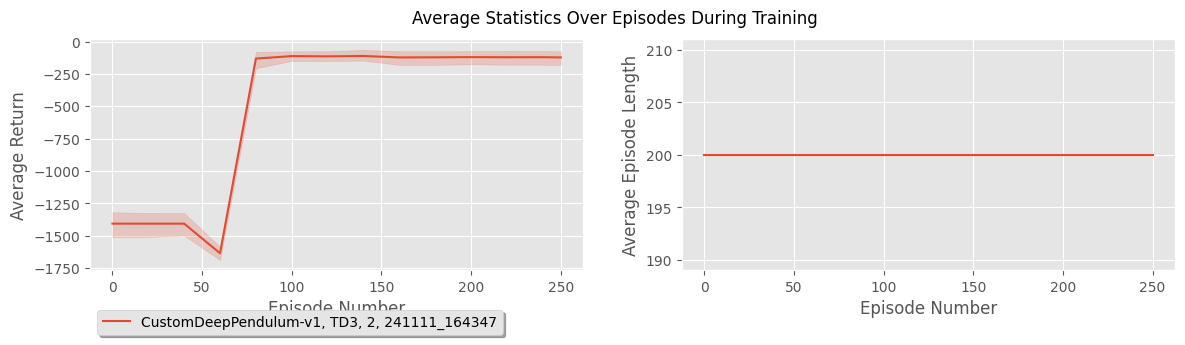

In [9]:
eval_params = edict()  # eval_params - evaluation settings for trained agent

eval_params.run_name00 = exp.run_name
eval_params.exp_type00 = exp.exp_type

# eval_params.run_name01 = "CartPole-v1__PPO__1__230302_224624"
# eval_params.exp_type01 = None

# eval_params.run_name02 = "CartPole-v1__PPO__1__230302_221245"
# eval_params.exp_type02 = None

agent_labels = []

episode_axis_limit = None

hf.plotter_agents_training_stats(eval_params, agent_labels, episode_axis_limit, plot_returns=True, plot_episode_len=True)

## TensorBoard Inline

Run the following lines to start-up Tensorboard. It will be displayed in an inline style. Alternatively, you can open a new tab in the browser and go to *localhost:6006* after start-up. If you use Tensorboard through this notebook, then you have to make sure that you terminate the Jupyter server by "Ctrl+C" once your session is finished. If not done in this way, you might run into problems starting it up again.

In [10]:
# %load_ext tensorboard
# %tensorboard --logdir runs --host localhost